<a href="https://colab.research.google.com/github/ruby199/generative_architecture/blob/main/BASIC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import the libraries

import torch, pdb # pdb is a library for debugging in python
from torch.utils.data import DataLoader # hold the training data so that we can iterate through the training data as we train the network
from torch import nn # can build deep learning architecture & models
from torchvision import transforms # transform out training data in different ways
from torchvision.datasets import MNIST # dataset composed of images of numbers
from torchvision.utils import make_grid # to build the grid of images to evaulate during the training - how the fake images created by the generator verses the real images
from tqdm.auto import tqdm # gives progress bar as training while procesing on iterable set of data
import matplotlib.pyplot as plt # allow us to plot the grid

In [17]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor is a muti dimensional array 128 x 784, channel is 1(greyscale) as we are going to use only balck/white images, size of data 28,28 as it's the smallest size, number of images we want to show as 16 for now
  # reshape size of the tensor (28 x 28) into 128 x 1 x 28 x 28 --> meaning we are going to process 128 picture at a time
  data = tensor.detach().cpu().view(-1,ch,*size) # we want to visualize what is contained in the variable(detach), bring it back to cpu(cpu), then restructure it(by "view") 
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) # 16 x 1 x 28 x 28 = 28 x 28 x 1 image in one of them is weigh*hight*channel, take the first num(16) pictures in 4 rows 4 columns, permute chages the order of the channels
  plt.imshow(grid) # display the content
  plt.show()



In [30]:
# setup of the main parameters and hyperparameters
epochs = 500 # setting a big number for now
cur_step = 0 
info_step = 300 # how many steps we want to show in the screen information about the current loss values & show visually and look at the images created by generator 

# accumulate the information (generate total loss)
mean_gen_loss = 0
mean_disc_loss = 0


# hyper-parameters 
z_dim = 64 # dim of latent space that we are going to learn (noice vector of the input of generator)
lr = 0.00001 # learning rate. speed of pushing them in the direction of the neg gradiant
loss_func = nn.BCEWithLogitsLoss() # pytorch code it for you (binary cross entropy)

# more hyper-parameters
bs = 128 # batch size, how many images we are going to process in the CPU
device = 'cuda' # library for parallel processing from Nvidia

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs) # going to hold our data, type of a structure call an iterator we will be able to call, then we will get Batches of the training data. // pytorch has a function called MNIST going to give all data itself, 
# MNIST has parameters of where to store the data, '.' root folder in this case, dowload true, transform it with this function
# shuffle will help training
# each stpes processes # of batch, each batch has 128 images
# Thus, number of steps? There are 60000 in MNIST dataset, and divided by (# of images/batch) which is 128 here
# = 60000 / 128 = 468.75
# from pytorch

In [31]:
# declar our models

## Generator
def genBlock(inp, out): # size of input and output as parameters
  return nn.Sequential(
      nn.Linear(inp, out), # This linear layer would perform linear computations between input&output 
      nn.BatchNorm1d(out), # 1d as we are using black & white 1d with a single channel, it is applied to the output of the dimension of the previous layer - help the training to be more stable when we use mutiple layers in NN
      nn.ReLU(inplace=True) # creates a nonlinear transformation, helps NN leawrning more complex functions
  ) # setting the number of blocks/layers of elements to be executed sequentially

# z_dim, the input noise latent vector (64 by default)
# i_dim: dim of the image 28x28=784
# base size of the hidden layer of the generator say for e.g.-> 128
class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128): 
    super().__init__()
    self.gen = nn.Sequential( # varaible gen (generator)
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256 (start increasing the size to generage an image of the size of image of the smallest dataset)
        genBlock(h_dim*2, h_dim*4), # 256, 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (=28x28), output is a single linear layer (fully connected layer) that is the size of the images of the dataset which is i_dim
        nn.Sigmoid(), # set the value to be between 0 and 1 
    )
    # function that is going to be executed when we basically run the instance of the class
  def forward(self, noise):
      return self.gen(noise)

# generates noise, z_dim is the size of the noise vector
def gen_noise(number, z_dim):
  return torch.randn(number,z_dim).to(device) # randn is a pytorch function that returns a tensor field with random numbers from a normal distrubution with mean of 0, variance of 1 (then store it into the gpu)

## Discriminator
def discBlock(inp, out): # size of the input, output as parameters, then return an immediate sequential structure
  return nn.Sequential(
      nn.Linear(inp, out), # liner layer input&output size
      nn.LeakyReLU(0.2) # LeakyReLU is a different type of non-linear function, with ReLU there might be dying ReLU as we are setting all neg value into 0 (LeakyReLU can give a small neg number instead of 0 in a certain slope)
      # 0.2 is a slope
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256): # input of the discriminator is image of the MNIST dataset
    super().__init__() # initialize the parent class
    self.disc=nn.Sequential( # large vaule into one number (output of the discriminator is one single value to say if the image is real orfake)
        discBlock(i_dim, h_dim*4), # 784, 1025
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )
  def forward(self, image):
      return self.disc(image)

In [32]:
gen = Generator(z_dim).to(device) # declare generator with par as the size of the noise vector and store into GPU
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr) # declare the optimizer - data structure that is in charge of optimization(calculating the gradians, do back propagation with chain rule, applying correct lr...), gen.parameters(), lr=lr are par we want to optimize
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [33]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [34]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([0, 3, 5, 2, 9, 1, 9, 8, 7, 2])


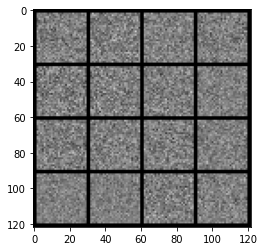

In [40]:
x,y = next(iter(dataloader)) # going to give the whole batch of 128 images
print(x.shape, y.shape) # the shape of the first & second value return
print(y[:10])

noise = gen_noise(bs, z_dim) # bs=batch size, z_dim = number of noise vector, 
fake = gen(noise) # pass the noise vector
show(fake) # generator the noise vector

In [43]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  noise = gen_noise(number, z_dim) # pass them through the generator 
  fake = gen(noise) 
  pred = disc(fake) # prediction of discriminator
  # compare the calculated generated loss to the value of one
  # compare the output of the discriminator to the targets, which is REAL (1)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)

  return gen_loss

def calc_disc_loss(loss_func, gen, disc, number, real, z_dim): # real is the set of real images
  noise = gen_noise(number, z_dim)
  fake = gen(noise) # pass noise vector through generator 
  disc_fake = disc(fake.detach()) # pass the generated fake image through the disciminator, detach: when pytorch back propagates the loss of the discriminator-we don't want to change the parameters of the generator when we are optimizing the discriminator 
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

  # same thing with the real images
  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  disc_loss = (disc_fake_loss + disc_real_loss)/2

  return disc_loss



  0%|          | 0/469 [00:00<?, ?it/s]

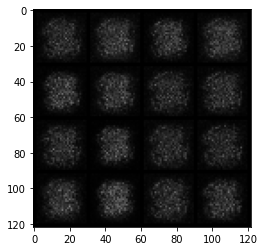

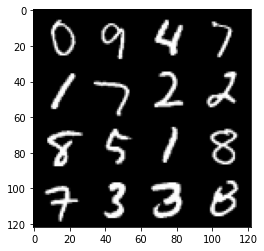

0: step 1200 / Gen loss: 9.856066923141473 / disc_loss: 0.012586226048103227/n


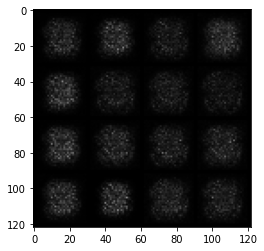

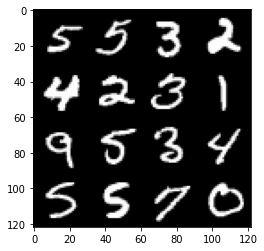

0: step 1500 / Gen loss: 6.750246939659118 / disc_loss: 0.014754817330588898/n


  0%|          | 0/469 [00:00<?, ?it/s]

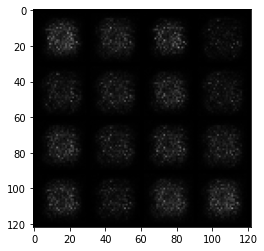

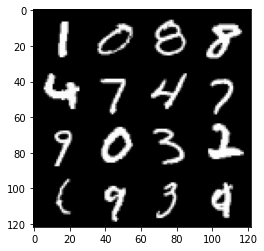

1: step 1800 / Gen loss: 5.547426336606342 / disc_loss: 0.01220216573526461/n


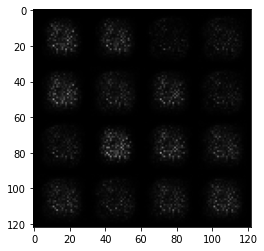

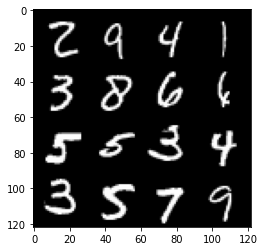

1: step 2100 / Gen loss: 5.156750222841899 / disc_loss: 0.010613542116867993/n


  0%|          | 0/469 [00:00<?, ?it/s]

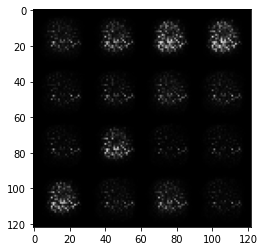

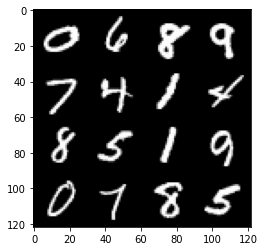

2: step 2400 / Gen loss: 5.129420577685041 / disc_loss: 0.009274859762129686/n


  0%|          | 0/469 [00:00<?, ?it/s]

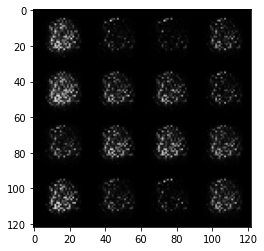

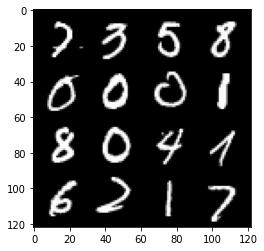

3: step 2700 / Gen loss: 5.306154095331831 / disc_loss: 0.00824131443010022/n


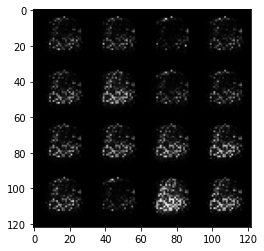

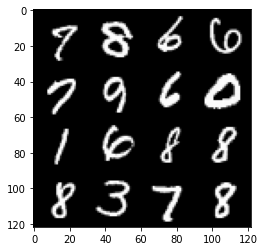

3: step 3000 / Gen loss: 5.805385451316835 / disc_loss: 0.007512452009832481/n


  0%|          | 0/469 [00:00<?, ?it/s]

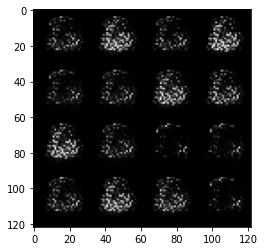

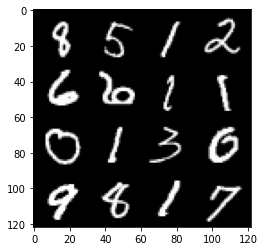

4: step 3300 / Gen loss: 5.961590456962585 / disc_loss: 0.007513261928688731/n


  0%|          | 0/469 [00:00<?, ?it/s]

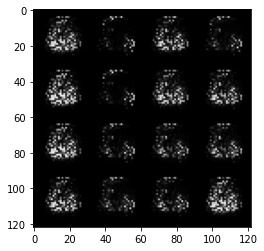

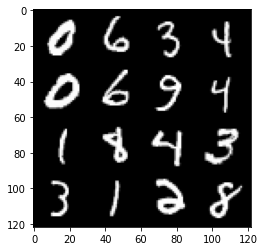

5: step 3600 / Gen loss: 6.340553720792139 / disc_loss: 0.005546521262731404/n


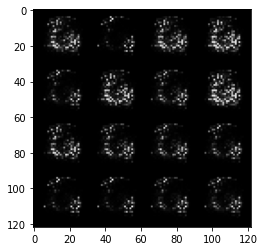

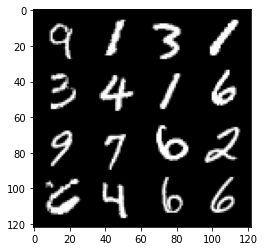

5: step 3900 / Gen loss: 6.4823940404256195 / disc_loss: 0.004781489457624657/n


  0%|          | 0/469 [00:00<?, ?it/s]

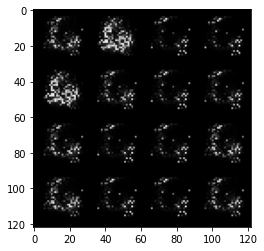

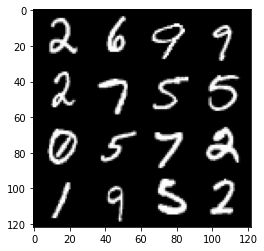

6: step 4200 / Gen loss: 6.932922954559326 / disc_loss: 0.004006603901507333/n


  0%|          | 0/469 [00:00<?, ?it/s]

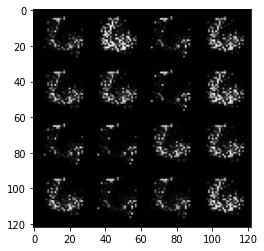

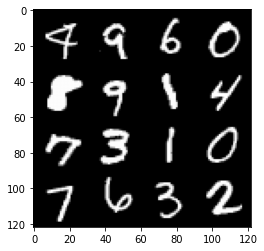

7: step 4500 / Gen loss: 7.265830548604328 / disc_loss: 0.00406270781434917/n


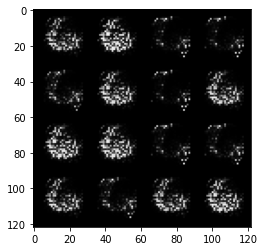

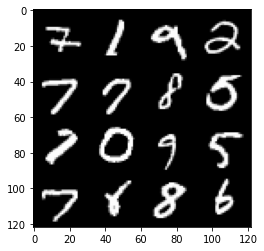

7: step 4800 / Gen loss: 7.792958788871765 / disc_loss: 0.0034479854356807968/n


  0%|          | 0/469 [00:00<?, ?it/s]

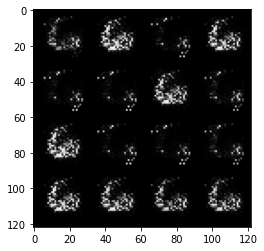

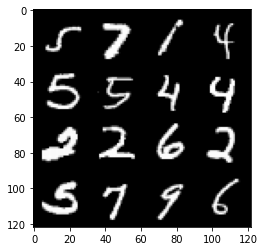

8: step 5100 / Gen loss: 7.110713990529376 / disc_loss: 0.004048296155524441/n


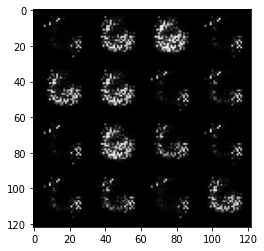

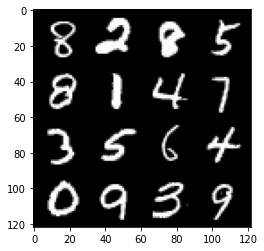

8: step 5400 / Gen loss: 6.373415360450748 / disc_loss: 0.004618242520761364/n


  0%|          | 0/469 [00:00<?, ?it/s]

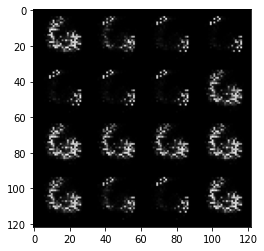

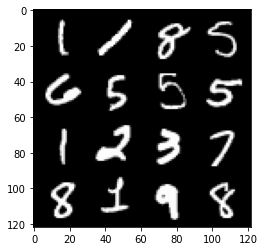

9: step 5700 / Gen loss: 6.762699983914692 / disc_loss: 0.003823677342152224/n


  0%|          | 0/469 [00:00<?, ?it/s]

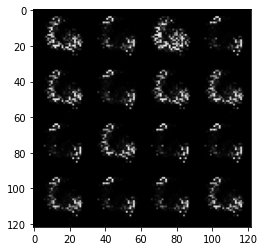

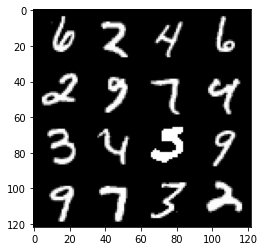

10: step 6000 / Gen loss: 6.849682594935098 / disc_loss: 0.002891912914928982/n


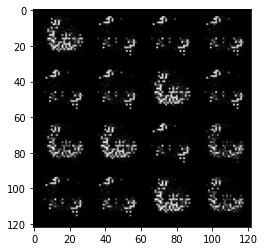

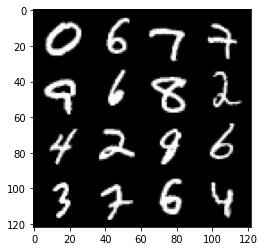

10: step 6300 / Gen loss: 6.9823716052373275 / disc_loss: 0.002299020299882009/n


  0%|          | 0/469 [00:00<?, ?it/s]

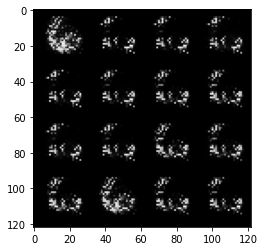

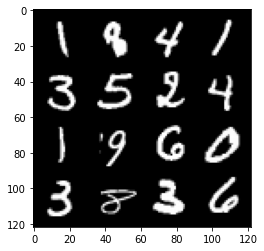

11: step 6600 / Gen loss: 6.760835498174038 / disc_loss: 0.002552276802695511/n


  0%|          | 0/469 [00:00<?, ?it/s]

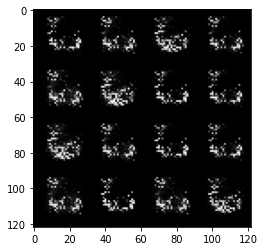

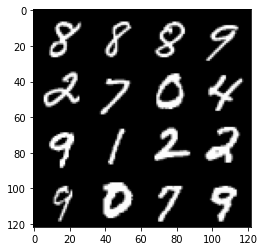

12: step 6900 / Gen loss: 7.802648646036784 / disc_loss: 0.0032636264947359427/n


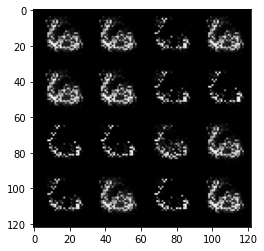

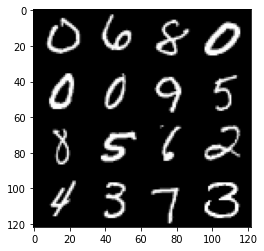

12: step 7200 / Gen loss: 10.390029036204023 / disc_loss: 0.0041619492546305994/n


  0%|          | 0/469 [00:00<?, ?it/s]

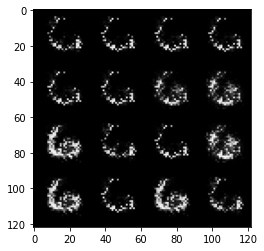

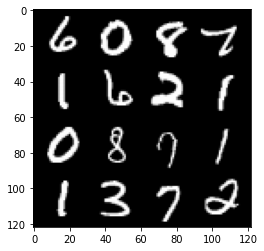

13: step 7500 / Gen loss: 8.231049720446267 / disc_loss: 0.00413723810440085/n


  0%|          | 0/469 [00:00<?, ?it/s]

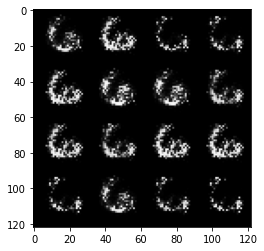

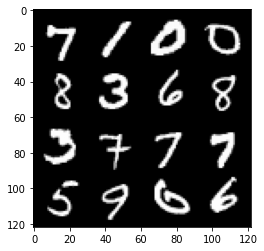

14: step 7800 / Gen loss: 7.523775455156964 / disc_loss: 0.004623122435295955/n


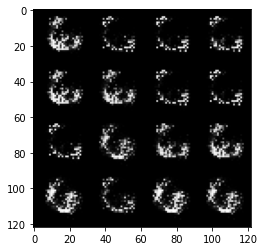

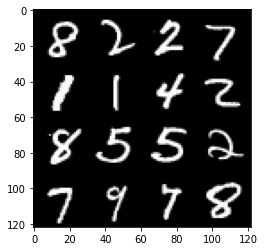

14: step 8100 / Gen loss: 7.041243120829266 / disc_loss: 0.0052855636942937675/n


  0%|          | 0/469 [00:00<?, ?it/s]

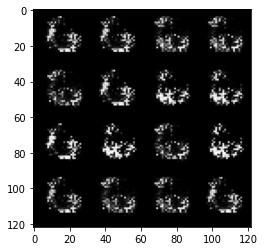

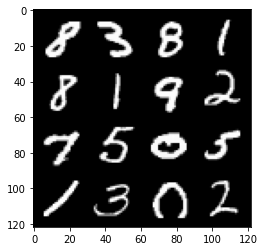

15: step 8400 / Gen loss: 6.423484587669373 / disc_loss: 0.0058571712449580985/n


  0%|          | 0/469 [00:00<?, ?it/s]

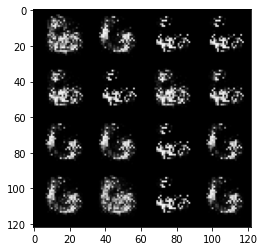

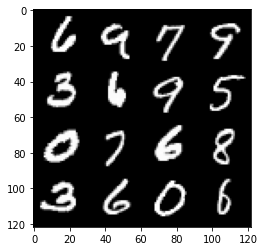

16: step 8700 / Gen loss: 7.1168547868728655 / disc_loss: 0.005988527684724736/n


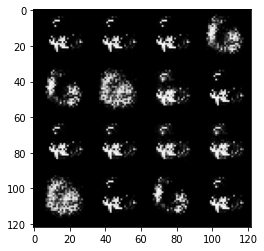

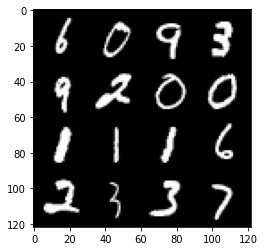

16: step 9000 / Gen loss: 6.387037698427836 / disc_loss: 0.006417540863816008/n


  0%|          | 0/469 [00:00<?, ?it/s]

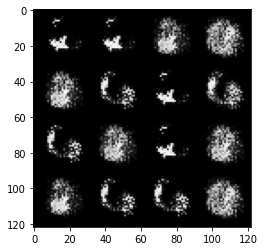

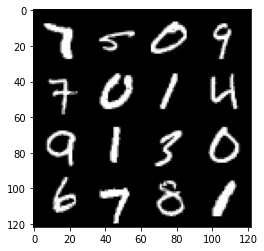

17: step 9300 / Gen loss: 6.282073543866476 / disc_loss: 0.009313503529216787/n


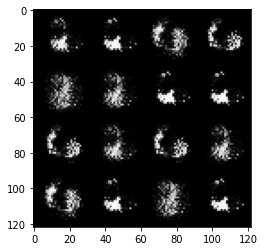

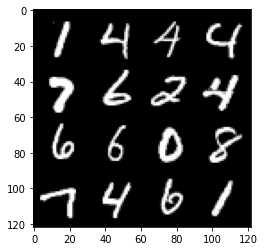

17: step 9600 / Gen loss: 5.717411748568211 / disc_loss: 0.013031715044441311/n


  0%|          | 0/469 [00:00<?, ?it/s]

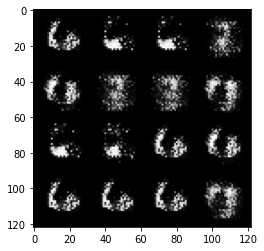

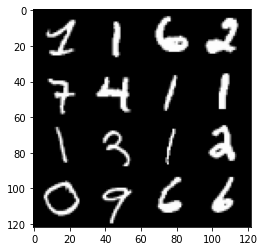

18: step 9900 / Gen loss: 5.455103084246319 / disc_loss: 0.01328094169885541/n


  0%|          | 0/469 [00:00<?, ?it/s]

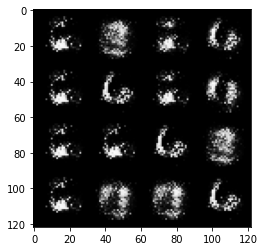

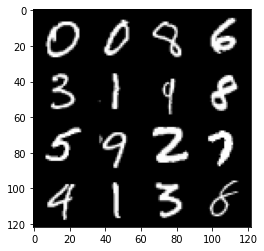

19: step 10200 / Gen loss: 5.740291663805643 / disc_loss: 0.015254425938085963/n


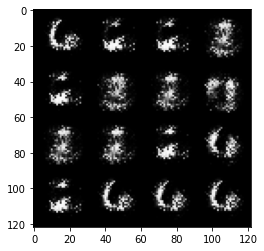

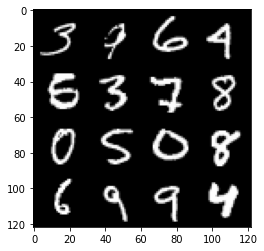

19: step 10500 / Gen loss: 5.50416865984599 / disc_loss: 0.014609656974983716/n


  0%|          | 0/469 [00:00<?, ?it/s]

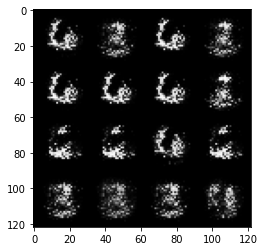

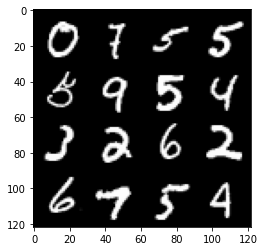

20: step 10800 / Gen loss: 5.4129271427790355 / disc_loss: 0.011596622162808974/n


  0%|          | 0/469 [00:00<?, ?it/s]

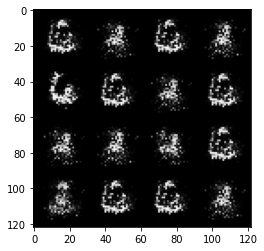

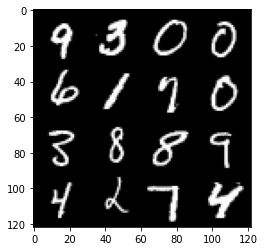

21: step 11100 / Gen loss: 5.613350389798486 / disc_loss: 0.011848611219320442/n


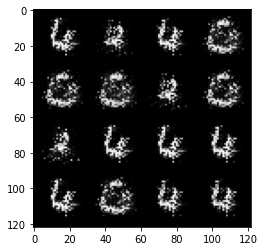

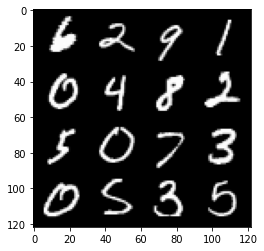

21: step 11400 / Gen loss: 5.658972616195677 / disc_loss: 0.012035756156158936/n


  0%|          | 0/469 [00:00<?, ?it/s]

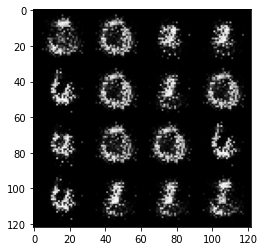

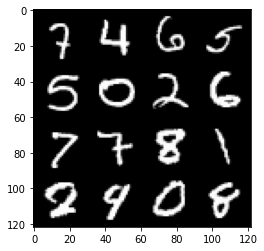

22: step 11700 / Gen loss: 5.464349223772685 / disc_loss: 0.01329689195302005/n


  0%|          | 0/469 [00:00<?, ?it/s]

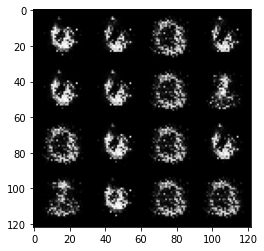

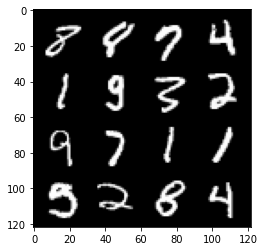

23: step 12000 / Gen loss: 5.540306448936465 / disc_loss: 0.01189558116331076/n


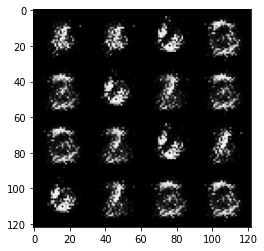

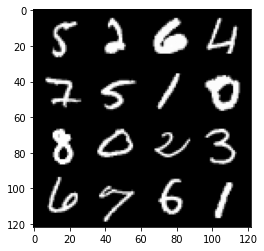

23: step 12300 / Gen loss: 5.5547013044357305 / disc_loss: 0.012463245820642142/n


  0%|          | 0/469 [00:00<?, ?it/s]

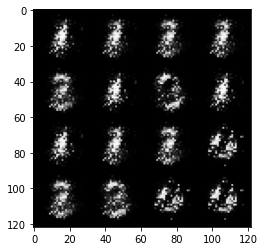

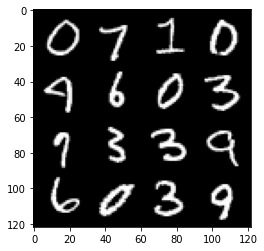

24: step 12600 / Gen loss: 5.476405742963155 / disc_loss: 0.013200289956293987/n


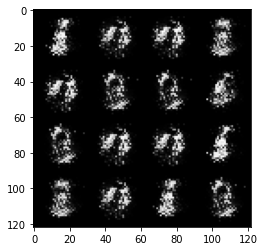

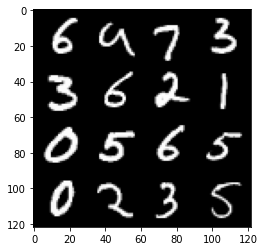

24: step 12900 / Gen loss: 5.449455625216169 / disc_loss: 0.01659924284555018/n


  0%|          | 0/469 [00:00<?, ?it/s]

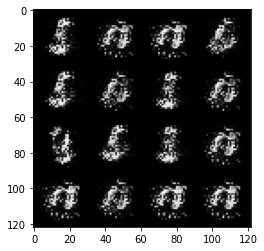

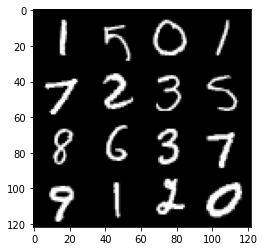

25: step 13200 / Gen loss: 5.455137961705527 / disc_loss: 0.014561450278076031/n


  0%|          | 0/469 [00:00<?, ?it/s]

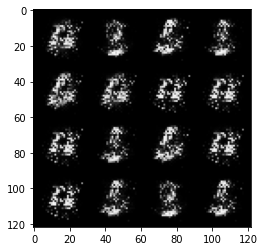

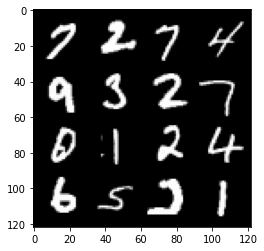

26: step 13500 / Gen loss: 5.486915434201557 / disc_loss: 0.012814227497049904/n


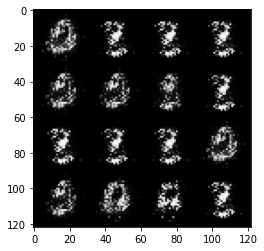

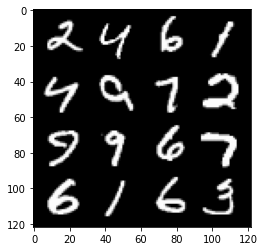

26: step 13800 / Gen loss: 5.6932322343190505 / disc_loss: 0.012072481303475794/n


  0%|          | 0/469 [00:00<?, ?it/s]

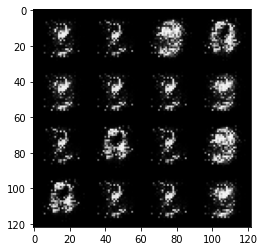

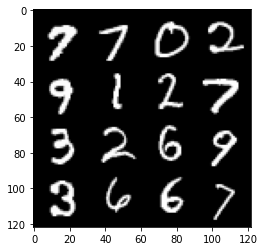

27: step 14100 / Gen loss: 5.713192888895672 / disc_loss: 0.012642263862459613/n


  0%|          | 0/469 [00:00<?, ?it/s]

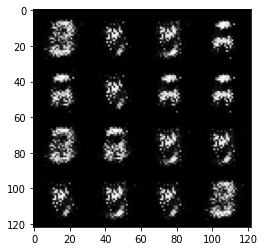

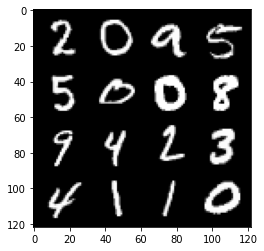

28: step 14400 / Gen loss: 5.80695856253306 / disc_loss: 0.015330273054229715/n


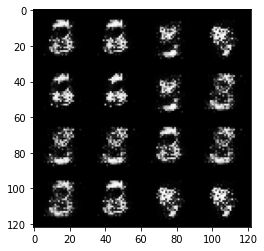

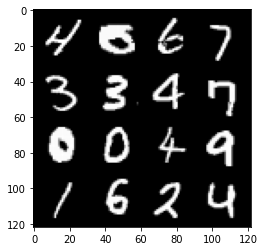

28: step 14700 / Gen loss: 5.821467016537979 / disc_loss: 0.014343092053507766/n


  0%|          | 0/469 [00:00<?, ?it/s]

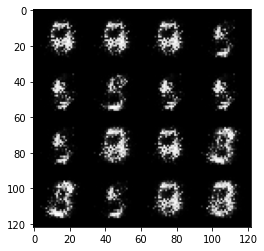

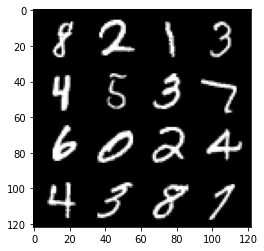

29: step 15000 / Gen loss: 5.5145812082290675 / disc_loss: 0.015454297528291732/n


  0%|          | 0/469 [00:00<?, ?it/s]

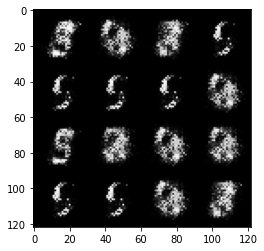

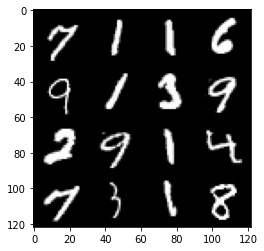

30: step 15300 / Gen loss: 5.6162591679890985 / disc_loss: 0.017345942888253682/n


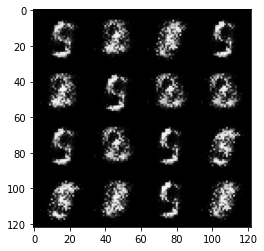

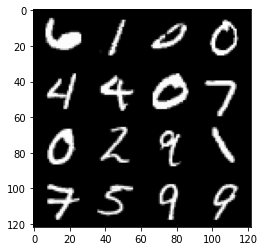

30: step 15600 / Gen loss: 5.152965863545742 / disc_loss: 0.020983906822899953/n


  0%|          | 0/469 [00:00<?, ?it/s]

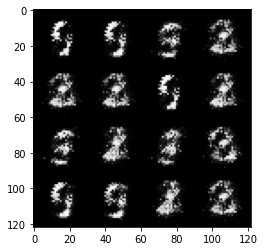

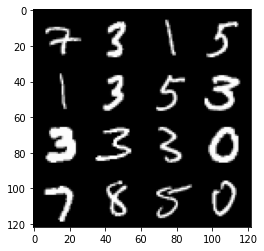

31: step 15900 / Gen loss: 5.256759500503538 / disc_loss: 0.02487222969066353/n


  0%|          | 0/469 [00:00<?, ?it/s]

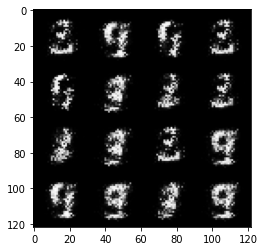

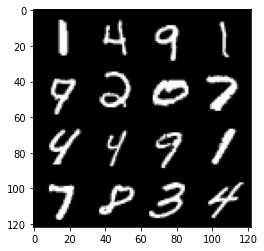

32: step 16200 / Gen loss: 5.0420219675699895 / disc_loss: 0.022948826464513957/n


In [ ]:
# training loop with different epochs

# How many steps?
### 60000 / 128 = 468.75 (60000MNIST # of images / 128 each batch) steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader): # we do not need the lable since it's not supervised learning, so it's left as _ 
    ### discriminator
    disc_opt.zero_grad() # set the gradiant of the disc_opt in to 0 
    cur_bs = len(real) # real : 128 x 28 x 28, # current batch size: length of the size of real images returned in each steps nby the data loader 
    real = real.view(cur_bs, -1) # 128 x 784 # reshape the real images using view into the size of the batch, keep the size of the batch make it to 1d: 784
    real = real.to(device)
    disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)

    disc_loss.backward(retain_graph=True) # take the lost value and back propagate to calculate al the gradients of NN, graph is kept in memory by setting "retain_graph=True"
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim) # we don't need the real images for the generator
    gen_loss.backward(retain_graph=True) # back prapagate it, retain_graph is optional parameter
    gen_opt.step()

    ### visualization & states
    mean_disc_loss += disc_loss.item()/info_step # to visualize every 300 steps, we accumulate it, item converts the nmber to standalone number
    mean_gen_loss += gen_loss.item()/info_step # we will be able to view the average of each loss

    # When do we show the information?
    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise = gen_noise(cur_bs, z_dim) # shows how the fake image looks compared to the real image, cur_bs is current batch size, z_dim is the size of the noise vector --> pass into the generator
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}/n")
      mean_gen_loss, mean_disc_loss = 0, 0 # set those mean var into 0 for the new step
    cur_step += 1
